<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [76]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [77]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [78]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [79]:
#dfnlp has advanced features 
print(dfnlp.shape)
print(dfppro.shape)

(404290, 21)
(404290, 17)


In [80]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
#df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)


In [81]:
df1.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [82]:
df2.head(2)

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [83]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [84]:
#merging these 3 dataframes
f= pd.merge(df1,df2, on = 'id')
final_df = pd.merge(df,f, on='id')

In [85]:
final_df.head(2) 

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h1> splitting dataset

In [86]:
y_true = df['is_duplicate']
print(y_true.shape)

X = final_df.drop(columns = ['is_duplicate'])
X.shape

(404290,)


(404290, 31)

In [87]:
#taking 100k datapoints
X= X[:100000]
y_true = y_true[:100000]
print(X.shape)
print(y_true.shape)

(100000, 31)
(100000,)


In [88]:
from sklearn.model_selection import train_test_split

In [89]:
X_train, X_test , Y_train, Y_test = train_test_split(X, y_true , stratify = y_true, test_size = 0.3)

In [90]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(70000, 31)
(70000,)
(30000, 31)
(30000,)


<h1> tfidf

In [91]:
#CHANGE
#tf-idf essay
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer1 = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000) #for vectoring all question1
vectorizer2 = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000) #for vectorizing all question2op

tfidf_version_q1_train = vectorizer1.fit_transform(X_train['question1'])
tfidf_version_q2_train = vectorizer2.fit_transform(X_train['question2'])

tfidf_version_q1_test = vectorizer1.transform(X_test['question1'])
tfidf_version_q2_test = vectorizer2.transform(X_test['question2'])

print("tfidf train q1",tfidf_version_q1_train.shape)
print("tfidf train q2",tfidf_version_q2_train.shape)

print("tfidf test q1",tfidf_version_q1_test.shape)
print("tfidf test q2",tfidf_version_q2_test.shape)

#vectorizer.get_feature_names()


tfidf train q1 (70000, 5000)
tfidf train q2 (70000, 5000)
tfidf test q1 (30000, 5000)
tfidf test q2 (30000, 5000)


<h1> concatenating all features

In [92]:
#as we've calculated the vectorizers for the questions 1 and 2, we can remove the actual questions from the table
#X_train, X_test 
a = X_train.drop(columns = ['question1', 'question2'])
b = X_test.drop(columns = ['question1', 'question2'])

In [94]:
#converting df1 into matrix
all_features_train = a.to_numpy()
print(all_features_train.shape)

all_features_test = b.to_numpy()
print(all_features_test.shape)

(70000, 29)
(30000, 29)


In [95]:
print(tfidf_version_q1_train.shape)
print(tfidf_version_q2_train.shape)

(70000, 5000)
(70000, 5000)


In [96]:
from scipy.sparse import hstack
x_train = hstack((all_features_train,tfidf_version_q1_train,tfidf_version_q2_train))
x_test = hstack((all_features_test,tfidf_version_q1_test,tfidf_version_q2_test))

In [97]:
print(x_train.shape)
print(x_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(70000, 10029)
(30000, 10029)
(70000,)
(30000,)


In [98]:
#we'll work with x_train, x_test, Y_train, Y_test

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [100]:
# This function plots the confusion matrices given y_i, y_i_hat. 
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h1> LR

For values of alpha =  1e-05 The log loss is: 0.6602902109101164
For values of alpha =  0.0001 The log loss is: 0.6602902109101164
For values of alpha =  0.001 The log loss is: 0.6602902109101164
For values of alpha =  0.01 The log loss is: 0.6602902109101164
For values of alpha =  0.1 The log loss is: 0.6221688269822667
For values of alpha =  1 The log loss is: 0.5981935230207817
For values of alpha =  10 The log loss is: 0.6019338749019397


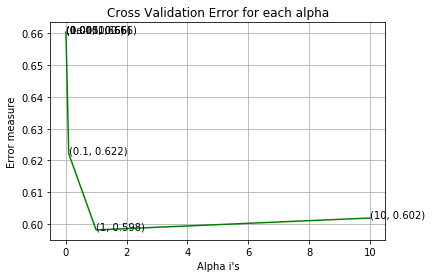

In [101]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, Y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  1 The train log loss is: 0.5985938344318813
For values of best alpha =  1 The test log loss is: 0.5981935230207817
Total number of data points : 30000


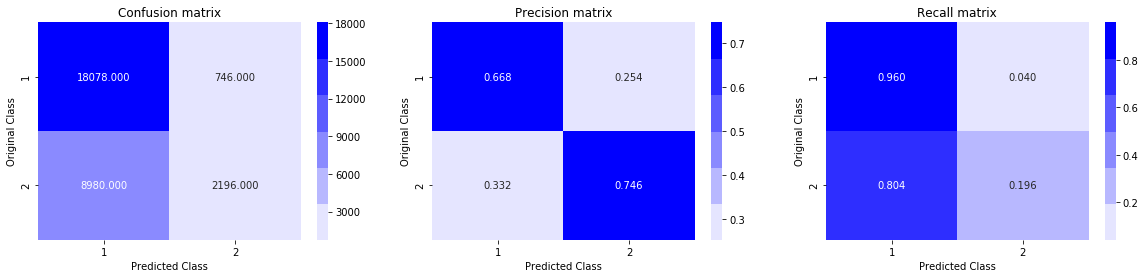

In [102]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, Y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

<h1> Linear SVM

For values of alpha =  1e-05 The log loss is: 0.6602902109101164
For values of alpha =  0.0001 The log loss is: 0.6602902109101164
For values of alpha =  0.001 The log loss is: 0.6602902109101164
For values of alpha =  0.01 The log loss is: 0.6602902109101164
For values of alpha =  0.1 The log loss is: 0.6602902109101164
For values of alpha =  1 The log loss is: 0.6080728117035794


/Users/namitagarwal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/namitagarwal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  10 The log loss is: 0.643110908735157


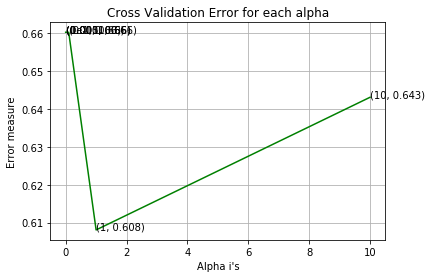

In [103]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(x_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, Y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  1 The train log loss is: 0.608332182535169
For values of best alpha =  1 The test log loss is: 0.6080728117035794
Total number of data points : 30000


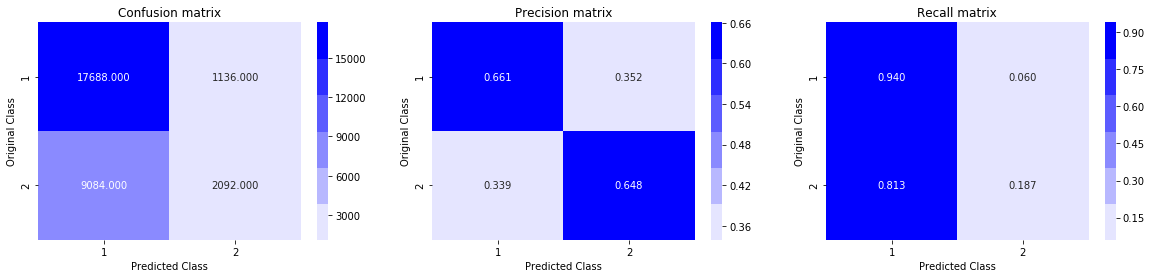

In [104]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, Y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

<H1>XGBOOST

In [105]:
#preparing data
print(X_train.shape)
print(X_test.shape) 

(70000, 31)
(30000, 31)


In [106]:
X_train.head(2) 
#x_train has all the other features already. 
#2 things to do-
    # calc w2vtfidf of q1 and q2 and add them to x_train dataframe
    #remove q1 and q2 columns from x_train ------ we'll get final df to build our model

,id,qid1,qid2,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
23292,23292,43641,43642,What should I do when my boyfriend tries to ma...,Does my boyfriend try to make me jealous?,0.749981,0.749981,0.749981,0.374995,0.749991,...,1,60,41,12,8,6.0,20.0,0.3,2,0
21844,21844,41070,41071,Teeth: What can be done to relieve a sinus too...,How do I explain sinus?,0.499975,0.199996,0.000000,0.000000,0.199996,...,1,53,23,10,5,0.0,15.0,0.0,3,1


In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions_train = list(X_train['question1']) + list(X_train['question2'])
#questions_test = list(X_test['question1']) + list(X_test['question2'])


tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions_train)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [108]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_lg')

In [109]:
#TRAIN- QUESTION1 
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_w2vtfidf'] = list(vecs1)

100%|██████████| 70000/70000 [12:32<00:00, 93.02it/s] 


In [110]:
#TRAIN - QUESTION2
vecs2 = []
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_w2vtfidf'] = list(vecs2)

100%|██████████| 70000/70000 [12:28<00:00, 93.58it/s] 


In [111]:
X_train.head(2)

,id,qid1,qid2,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,q1_feats_w2vtfidf,q2_feats_w2vtfidf
23292,23292,43641,43642,What should I do when my boyfriend tries to ma...,Does my boyfriend try to make me jealous?,0.749981,0.749981,0.749981,0.374995,0.749991,...,41,12,8,6.0,20.0,0.3,2,0,"[-8.424806576222181, 0.9366077113663778, -17.4...","[-8.191828240640461, 0.2912880629301071, -15.2..."
21844,21844,41070,41071,Teeth: What can be done to relieve a sinus too...,How do I explain sinus?,0.499975,0.199996,0.000000,0.000000,0.199996,...,23,10,5,0.0,15.0,0.0,3,1,"[-3.0936635360121727, 10.660027235746384, -21....","[-4.418224263936281, 6.5445438623428345, -12.0..."


In [112]:
df_w2v_q1_train = pd.DataFrame(X_train.q1_feats_w2vtfidf.values.tolist(), index = X_train.index)
df_w2v_q2_train = pd.DataFrame(X_train.q2_feats_w2vtfidf.values.tolist(), index = X_train.index)

#these to dfs has the w2vtfidf vectors all q1 and q2. we need to add these 2 dfs wit X_train
#(and remove q1 and q2 from X_train)

In [113]:
print(df_w2v_q1_train.shape)
print(df_w2v_q2_train.shape)

(70000, 300)
(70000, 300)


In [114]:
X_train = X_train.drop(['question1','question2','q1_feats_w2vtfidf', 'q2_feats_w2vtfidf'], axis= 1)

In [117]:
#merging
df_w2v_q1_train['id']= X_train['id']
df_w2v_q2_train['id']= X_train['id']

a = X_train.merge(df_w2v_q1_train)

In [119]:
x_train = a.merge(df_w2v_q2_train, on= 'id')

In [120]:
x_train.head(2)

,id,qid1,qid2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,23292,43641,43642,0.749981,0.749981,0.749981,0.374995,0.749991,0.499996,1.0,...,1.300720,4.119985,-0.093945,0.847261,9.988617,4.752702,0.223709,1.818404,6.422255,1.883664
1,21844,41070,41071,0.499975,0.199996,0.000000,0.000000,0.199996,0.099999,0.0,...,6.477132,7.215566,-2.876628,-3.243105,4.812498,-2.211799,-4.148317,5.269910,13.247503,-0.407079


In [121]:
x_train.shape

(70000, 629)

In [122]:
#TEST- QUESTION1 
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_w2vtfidf'] = list(vecs1)

100%|██████████| 30000/30000 [05:20<00:00, 90.98it/s] 


In [123]:
#TEST - QUESTION2
vecs2 = []
for qu2 in tqdm(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_w2vtfidf'] = list(vecs2)

100%|██████████| 30000/30000 [07:04<00:00, 44.27it/s]


In [126]:
df_w2v_q1_test = pd.DataFrame(X_test.q1_feats_w2vtfidf.values.tolist(), index = X_test.index)
df_w2v_q2_test = pd.DataFrame(X_test.q2_feats_w2vtfidf.values.tolist(), index = X_test.index)

#these to dfs has the w2vtfidf vectors all q1 and q2. we need to add these 2 dfs wit X_test
#(and remove q1 and q2 from X_test)

In [127]:
print(df_w2v_q1_test.shape)
print(df_w2v_q2_test.shape)

(30000, 300)
(30000, 300)


In [128]:
df_w2v_q1_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
70088,-7.946679,42.377756,14.141334,1.573851,14.239119,2.016348,-11.095601,-19.181919,-18.546331,169.390172,...,-22.254735,12.383118,23.587358,-24.346370,18.584083,5.432018,3.282576,15.620539,18.536039,36.467731
45003,-8.925256,7.512833,-5.891377,-10.467991,8.289378,-3.709982,-1.875166,0.574685,-9.961686,57.496801,...,-8.324280,-0.965381,-13.069871,-7.925455,4.588310,2.477451,-7.239396,-5.052628,-0.799803,15.056445


In [129]:
X_test = X_test.drop(['question1','question2','q1_feats_w2vtfidf', 'q2_feats_w2vtfidf'], axis= 1)

In [130]:
#merging
df_w2v_q1_test['id']= X_test['id']
df_w2v_q2_test['id']= X_test['id']

In [131]:
a = X_test.merge(df_w2v_q1_test)

In [132]:
x_test = a.merge(df_w2v_q2_test, on='id')

In [133]:
x_test.head(2)

,id,qid1,qid2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,70088,120861,120862,0.499988,0.181817,0.999967,0.333330,0.714276,0.185184,0.0,...,3.810159,6.310952,1.363531,-3.729044,14.501432,11.037940,0.371790,1.483639,-0.549864,1.716092
1,45003,80697,80698,0.249994,0.249994,0.999975,0.999975,0.624992,0.624992,0.0,...,-1.517032,-1.992796,-15.878807,-7.423772,5.107274,5.331146,-7.988786,-1.772342,1.621201,17.745452


In [136]:
#now working with x_train, x_test, Y_train, Y_test
print(x_train.shape)
print(x_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(70000, 629)
(30000, 629)
(70000,)
(30000,)


In [137]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [138]:
params = { 
        'eta': [0.1,0.2,0.3],
        'max_depth': [3, 4, 5]
        }

In [139]:
xgb_model = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', 
                    silent=True, nthread=1)#eval_metric = 'logloss',

In [140]:
rs = RandomizedSearchCV(xgb_model,
                                params,
                                n_iter=20,
                                scoring="roc_auc",
                                n_jobs=1,
                                verbose=2)

#bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)



In [141]:
rs.fit(x_train, Y_train) 

/Users/namitagarwal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=3, eta=0.1 ............................................
[CV] ............................. max_depth=3, eta=0.1, total=29.5min
[CV] max_depth=3, eta=0.1 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 29.5min remaining:    0.0s


[CV] ............................. max_depth=3, eta=0.1, total=28.6min
[CV] max_depth=3, eta=0.1 ............................................
[CV] ............................. max_depth=3, eta=0.1, total=27.3min
[CV] max_depth=4, eta=0.1 ............................................
[CV] ............................. max_depth=4, eta=0.1, total=34.8min
[CV] max_depth=4, eta=0.1 ............................................
[CV] ............................. max_depth=4, eta=0.1, total=34.8min
[CV] max_depth=4, eta=0.1 ............................................
[CV] ............................. max_depth=4, eta=0.1, total=36.5min
[CV] max_depth=5, eta=0.1 ............................................
[CV] ............................. max_depth=5, eta=0.1, total=44.6min
[CV] max_depth=5, eta=0.1 ............................................
[CV] ............................. max_depth=5, eta=0.1, total=44.0min
[CV] max_depth=5, eta=0.1 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 1356.3min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=600,
                                           n_jobs=1, nthread=1,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=True, subsample=1,
                                           verbosity=1),
       

In [142]:
print('\n All results:')
print(rs.cv_results_)
print('\n Best estimator:')
print(rs.best_estimator_) 
print('\n Best hyperparameters:')
print(rs.best_params_)
results = pd.DataFrame(rs.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([ 1706.2939469 ,  2119.59387175,  2612.89400768,  1723.40173467,
        2093.62324842,  2599.09692025,  1711.11571097, 10026.41755144,
        2516.86632927]), 'std_fit_time': array([5.24454887e+01, 4.77402197e+01, 6.19609201e+01, 1.56799884e+02,
       4.49309494e+01, 9.60664916e+01, 3.18321673e+00, 1.12246524e+04,
       3.89365559e+01]), 'mean_score_time': array([2.10787098, 1.96784965, 2.04233535, 1.35862931, 2.62691164,
       1.76622502, 1.14382577, 1.38635302, 1.90005334]), 'std_score_time': array([0.37534818, 0.30851346, 0.35518108, 0.41512679, 0.57292403,
       0.10320228, 0.00480241, 0.0679949 , 0.49090643]), 'param_max_depth': masked_array(data=[3, 4, 5, 3, 4, 5, 3, 4, 5],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_eta': masked_array(data=[0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3],
             mask=[False, False, Fal

In [143]:
#using the best parameters
best_params = {'base_score': 0.5, 'booster' : 'gbtree', 'colsample_bylevel' : 1,
              'colsample_bynode' : 1, 'colsample_bytree' : 1, 'eta':0.1, 'gamma' : 0,
              'learning_rate': 0.02, 'max_delta_step' : 0, 'max_depth' : 5,
              'min_child_weight' : 1, 'missing' : None, 'n_estimators' : 600, 'n_jobs' : 1,
              'nthread' : 1, 'objective' : 'binary:logistic', 'random_state' : 0,
              'reg_alpha' : 0, 'reg_lambda' : 1, 'scale_pos_weight' : 1, 
              'silent' : True, 'subsample' : 1, 'verbosity' : 1}


In [144]:
d_train = xgb.DMatrix(x_train, label=Y_train) 
d_test = xgb.DMatrix(x_test, label=Y_test) 

In [145]:
watchlist = [(d_train, 'train'), (d_test, 'valid')] 

In [146]:
bst = xgb.train(best_params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10) 

[0]	train-error:0.216471	valid-error:0.218067
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 20 rounds.
[10]	train-error:0.207257	valid-error:0.208
[20]	train-error:0.202757	valid-error:0.202633
[30]	train-error:0.196514	valid-error:0.195767
[40]	train-error:0.195414	valid-error:0.194367
[50]	train-error:0.194243	valid-error:0.193133
[60]	train-error:0.191557	valid-error:0.191133
[70]	train-error:0.188571	valid-error:0.189067
[80]	train-error:0.187857	valid-error:0.187467
[90]	train-error:0.186757	valid-error:0.187167
[100]	train-error:0.185986	valid-error:0.1866
[110]	train-error:0.185143	valid-error:0.185167
[120]	train-error:0.183529	valid-error:0.184367
[130]	train-error:0.182729	valid-error:0.184067
[140]	train-error:0.181686	valid-error:0.184467
[150]	train-error:0.180843	valid-error:0.183467
[160]	train-error:0.179057	valid-error:0.182767
[170]	train-error:0.178	valid-error:0.182167
[180]	tr

In [147]:
xgdmat = xgb.DMatrix(x_train,Y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

The test log loss is: 0.34764596178224894


Total number of data points : 30000


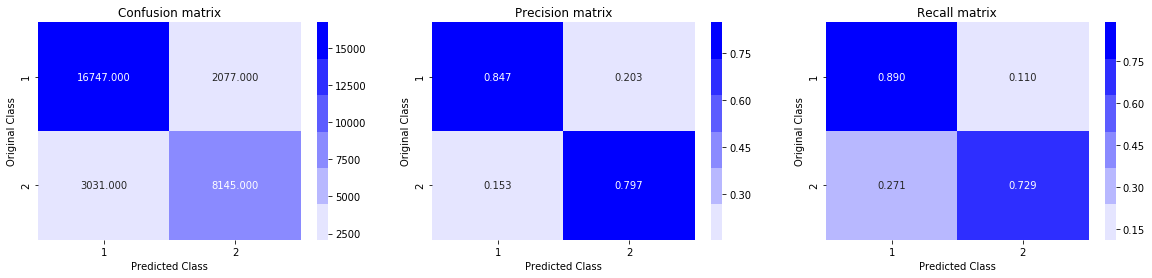

In [148]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)


<h1> Conclusion

In [149]:
from prettytable import PrettyTable

In [150]:
x= PrettyTable()

In [151]:
x.field_names= ['model','test log-loss']

In [152]:
x.add_row(['LR',0.5981935230207817])
x.add_row(['SVM',0.6080728117035794])
x.add_row(['XGBoost',0.34764596178224894])  

In [153]:
print(x)

+---------+---------------------+
|  model  |    test log-loss    |
+---------+---------------------+
|    LR   |  0.5981935230207817 |
|   SVM   |  0.6080728117035794 |
| XGBoost | 0.34764596178224894 |
+---------+---------------------+


<h1>Summary

1) dataset was looked over and various features were thought of
2) basic and advanced features were calculated and stored in dataframes
3) we'd 2 columns question1 and question2 - for which we had to calculate the tfidf features.
4) before calculating that, i spilt the data into train and test in 70-30 ratio.
5) i found tfidf features for question1 and question2 for both train and test dataset.
6) all the basic and advanced features were combined with the tfidf sparse features of question1 and question2 using hstack. With this we had formed our x_train and x_test which we used to build various models.
7) 2 models were built using this data- LR, Linear SVM
8) XGBoost model was built with tfidf w2v features of question1 and question2.
9) results were combined through prettyTable.